# Trading Strategy Development

In [287]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

In [288]:
# ============================
# Chargement des données
# ============================

def charger_donnees_traitees(date_debut, date_fin, sentiment_cols):
    """
    Charge et prépare les données entre deux dates données, filtre les tweets neutres,
    et retourne les sentiments séparés (_verified, _non_verified), le nombre de tweets, et les données boursières.
    La pondération des sentiments est désormais effectuée par le modèle.
    """
    # 1. Chargement et prétraitement des données brutes
    df = pd.read_csv(r'C:\Users\selim\Desktop\Data_total\All_tweets.csv')
    df = df.drop_duplicates(subset="id")
    df['query_date'] = pd.to_datetime(df['query_date'])
    df['year'] = df['query_date'].dt.year
    df['month'] = df['query_date'].dt.month
    df = df.sort_values(by='query_date').reset_index(drop=True)

    # 2. Filtrage selon les dates spécifiées
    date_debut = pd.to_datetime(date_debut)
    date_fin = pd.to_datetime(date_fin)
    df = df[(df['query_date'] >= date_debut) & (df['query_date'] <= date_fin)]

    # 3. Filtrage des tweets neutres
    for col in sentiment_cols:
        df = df[df[col].abs() >= 0.1]

    # 4. Nombre de tweets par jour (après filtrage)
    df_nb_tweets = df.groupby('query_date').size().rename('Nb_tweets').to_frame()

    # 5. Séparation verified / non_verified
    df_verified = df[df['verified']]
    df_non_verified = df[~df['verified']]

    # 6. Agrégation journalière des sentiments
    daily_verified = df_verified.groupby(['query_date', 'year', 'month'])[sentiment_cols].mean()
    daily_non_verified = df_non_verified.groupby(['query_date', 'year', 'month'])[sentiment_cols].mean()

    # 7. Fusion des sentiments (conserve les colonnes _verified et _non_verified)
    df_combined = pd.merge(daily_verified, daily_non_verified, 
                           left_index=True, right_index=True, 
                           suffixes=('_verified', '_non_verified'))

    # 8. Construction du DataFrame final de sentiment
    df_combined.reset_index(inplace=True)
    df_combined.rename(columns={'query_date': 'date'}, inplace=True)
    df_combined['date'] = pd.to_datetime(df_combined['date'])

    # 9. Ajout du nombre de tweets
    df_combined = df_combined.merge(df_nb_tweets, left_on='date', right_index=True, how='left')
    df_combined['coefficient'] = df_combined['Nb_tweets'] / df_combined['Nb_tweets'].max()

    # 10. Téléchargement des données boursières
    df_market = yf.download("TSLA", start=str(date_debut.date()), end=str(date_fin.date()), interval="1d")
    if isinstance(df_market.columns, pd.MultiIndex):
        df_market.columns = df_market.columns.get_level_values(0)

    df_market = df_market[["Open", "High", "Low", "Close", "Volume"]]
    df_market['date'] = pd.to_datetime(df_market.index)
    df_market.reset_index(drop=True, inplace=True)

    # 11. Fusion finale avec les données de marché
    df_final = pd.merge(df_combined, df_market, on="date", how="inner")

    return df_final


data = charger_donnees_traitees('01/02/2022','01/05/2023', [
            'SENTIMENT_VADER',
            'SENTIMENT_FinancialBERT-Sentiment-Analysis',
            'SENTIMENT_distilroberta-finetuned-financial-news-sentiment-analysis',
            'SENTIMENT_deberta-v3-ft-financial-news-sentiment-analysis'
        ])
data.head()

[*********************100%***********************]  1 of 1 completed


,date,year,month,SENTIMENT_VADER_verified,SENTIMENT_FinancialBERT-Sentiment-Analysis_verified,SENTIMENT_distilroberta-finetuned-financial-news-sentiment-analysis_verified,SENTIMENT_deberta-v3-ft-financial-news-sentiment-analysis_verified,SENTIMENT_VADER_non_verified,SENTIMENT_FinancialBERT-Sentiment-Analysis_non_verified,SENTIMENT_distilroberta-finetuned-financial-news-sentiment-analysis_non_verified,SENTIMENT_deberta-v3-ft-financial-news-sentiment-analysis_non_verified,Nb_tweets,coefficient,Open,High,Low,Close,Volume
0,2022-01-03,2022,1,0.60755,1.0,1.0,1.0,0.516033,1.000000,1.000000,1.000000,8,0.275862,382.583344,400.356659,378.679993,399.926666,103931400
1,2022-01-04,2022,1,-0.63690,-1.0,1.0,1.0,0.097400,0.600000,0.200000,0.200000,6,0.206897,396.516663,402.666656,374.350006,383.196655,100248300
2,2022-01-05,2022,1,0.38760,1.0,1.0,1.0,0.361200,1.000000,1.000000,1.000000,4,0.137931,382.216675,390.113342,360.336670,362.706665,80119800
3,2022-01-06,2022,1,0.56790,1.0,1.0,1.0,-0.415500,-0.333333,-0.333333,-0.333333,5,0.172414,359.000000,362.666656,340.166656,354.899994,90336600
4,2022-01-07,2022,1,0.13760,0.0,0.0,0.0,0.085500,0.333333,0.333333,0.333333,5,0.172414,360.123322,360.309998,336.666656,342.320007,84164700


In [289]:
# ============================
# Définition de la classe de modèle de trading
# ============================
import random
class SentimentTradingModel:
    def __init__(self, weights, buy_threshold, sell_threshold, sentiment_cols,weight_verified, rolling_days=1, initial_cash=1000):
        """
        Initialise le modèle avec les paramètres fournis.
        """
        self.weights = weights
        self.buy_threshold = buy_threshold
        self.sell_threshold = sell_threshold
        self.rolling_days = rolling_days
        self.initial_cash = initial_cash
        self.sentiment_cols = sentiment_cols
        self.weight_verified = weight_verified
        self.weight_non_verified = 1 - weight_verified

    def print_model_params(self):
        """
        Affiche les paramètres actuels du modèle.
        """
        print(f"Poids : {self.weights}")
        print(f'sentiment_cols : {self.sentiment_cols}')
        print(f"Seuil d'achat : {self.buy_threshold}")
        print(f"Seuil de vente : {self.sell_threshold}")
        print(f"Jours de roulage : {self.rolling_days}")
        
    
    def return_model_params(self):
        """
        Retourne les paramètres actuels du modèle sous forme de dictionnaire.
        """
        return {
            'weights': self.weights,
            'buy_threshold': self.buy_threshold,
            'sell_threshold': self.sell_threshold,
            'rolling_days': self.rolling_days,
            'sentiment_cols': self.sentiment_cols,
        }

    def combine_sentiments(self, df):
        """
        Combine les sentiments en utilisant la moyenne pondérée.
        """
        df_combined = df[self.sentiment_cols].copy()
        df_combined['combined_sentiment'] = np.dot(df_combined, self.weights)
        return df_combined

    def generate_signal(self, df):
        """
        Génère les signaux d'achat/vente/attente selon les sentiments combinés.
        """
        df = df.copy()
        df['combined_sentiment'] = sum(w * df[col] for w, col in zip(self.weights, self.sentiment_cols))

        if self.rolling_days > 1:
            df['combined_sentiment'] = df['combined_sentiment'].rolling(self.rolling_days, min_periods=1).mean()

        df['signal'] = 0
        df.loc[df['combined_sentiment'] > self.buy_threshold, 'signal'] = 1
        df.loc[df['combined_sentiment'] < self.sell_threshold, 'signal'] = -1
        return df
    
    def apply_sentiment_weights(self, df):
        """
        Applique la pondération verified / non_verified pour chaque modèle de sentiment.
        Ajoute les colonnes finales dans df : SENTIMENT_<modèle> (pondérées).
        """
        df = df.copy()
        for col in self.sentiment_cols:
            verified_col = f"{col}_verified"
            non_verified_col = f"{col}_non_verified"
            
            df[col] = (
                self.weight_verified * df[verified_col] +
                self.weight_non_verified * df[non_verified_col]
            )
        return df
    
    def train(self, df_train, n_iter=500):
        """
        Optimisation des hyperparamètres avec une recherche aléatoire.
        """
        best_return = -np.inf
        best_params = {}

        for _ in range(n_iter):
            # Choix aléatoire des hyperparamètres
            buy = random.uniform(0, 1)
            sell = random.uniform(-1, 0)
            weights = random.choice([
                [1, 0, 0, 0],
                [0, 1, 0, 0],
                [0, 0, 1, 0],
                [0, 0, 0, 1],
                (0.5 * np.array([1, 1, 0, 0])).tolist(),
                (0.5 * np.array([1, 0, 1, 0])).tolist(),
                (0.5 * np.array([0, 1, 1, 0])).tolist(),
                (0.5 * np.array([1, 0, 0, 1])).tolist(),
                (0.5 * np.array([0, 1, 0, 1])).tolist(),
                (1/3 * np.array([1, 1, 1, 0])).tolist(),
                (1/3 * np.array([1, 0, 1, 1])).tolist(),
                (1/3 * np.array([0, 1, 1, 1])).tolist(),
                (1/3 * np.array([1, 1, 0, 1])).tolist(),
                (0.5 * np.array([0, 0, 1, 1])).tolist()
            ])
            weight_verified = random.uniform(0, 1)
            weight_non_verified = 1 - weight_verified

            # Appliquer les poids verified
            self.weight_verified = weight_verified
            self.weight_non_verified = weight_non_verified
            self.buy_threshold = buy
            self.sell_threshold = sell
            self.weights = weights

            df_weighted = self.apply_sentiment_weights(df_train)
            df_signals = self.generate_signal(df_weighted)

            position = 0
            cash = self.initial_cash

            for _, row in df_signals.iterrows():
                price = row['Close']
                if row['signal'] == 1 and position == 0:
                    position = (cash-1) / price
                    cash = 0
                elif row['signal'] == -1 and position > 0:
                    cash = position * price - 1
                    position = 0

            final_value = cash + position * df_signals.iloc[-1]['Close']
            ret = final_value - self.initial_cash

            if ret > best_return:
                best_return = ret
                best_params = {
                    'buy_threshold': buy,
                    'sell_threshold': sell,
                    'weights': weights,
                    'weight_verified': weight_verified
                }

        # Mise à jour des meilleurs paramètres
        self.buy_threshold = best_params['buy_threshold']
        self.sell_threshold = best_params['sell_threshold']
        self.weights = best_params['weights']
        self.weight_verified = best_params['weight_verified']
        self.weight_non_verified = 1 - self.weight_verified

    def test (self, df_test):
        """
        Teste le modèle sur un ensemble de données donné.
        """
        df_signals = df_test.copy()

        df_signals['signal'] = df_signals.apply(
            lambda row: self.generate_signal(
                np.dot(row[self.sentiment_cols], self.weights)
            ), axis=1
        )

        position = 0
        cash = self.initial_cash

        for _, row in df_signals.iterrows():
            price = row['Close']
            if row['signal'] == 1 and position == 0:
                position = (cash-1) / price
                cash = 0
            elif row['signal'] == -1 and position > 0:
                cash = position * price - 1
                position = 0

        final_value = cash + position * df_signals.iloc[-1]['Close']
        ret = final_value - self.initial_cash

        return ret


In [290]:
# ============================
# Définition de la fonction de simulation
# ============================

def simuler_marche_journalier(cash, model, date_debut,date_fin, sentiment_cols):
    """
    Simule les décisions d'achat/vente jour après jour en recalibrant le modèle à chaque nouvelle journée.
    """
    # 1. Charger les données pour toutes les années demandées
    df = charger_donnees_traitees(date_debut,date_fin, sentiment_cols)

    premier_mois = df['date'].min()
    premiere_annee = df['date'].min().year

    jours_test = df[
        (df['date'].dt.year > premiere_annee) | 
        ((df['date'].dt.year == premiere_annee) & (df['date'].dt.month > premier_mois.month))
    ]['date'].unique()

    position = 0
    historique = {
        'date': [],
        'signal': [],
        'position': [],
        'valeur_portefeuille': [],
        'Close': []
    }

    cash_initial = cash

    historique_model = {
        'weights': [],
        'buy_threshold': [],
        'sell_threshold': [],
        'weight_verified': [],
        'weight_non_verified': []
    }

    for jour in jours_test:
        df_train = df[(df['date'] < jour) & (df['date'] >= (jour - pd.DateOffset(years=1)))]
        df_today = df[df['date'] == jour]

        if df_today.empty or df_train.empty:
            continue

        # Entraînement et génération du signal
        df_train = model.apply_sentiment_weights(df_train)
        model.train(df_train)
        df_today = model.apply_sentiment_weights(df_today)
        df_signal = model.generate_signal(df_today)
        
        historique_model['weights'].append(model.weights)
        historique_model['buy_threshold'].append(model.buy_threshold)
        historique_model['sell_threshold'].append(model.sell_threshold)
        historique_model['weight_verified'].append(model.weight_verified)
        historique_model['weight_non_verified'].append(model.weight_non_verified)
        if df_signal.empty:
            continue

        signal = df_signal['signal'].iloc[0]
        prix = df_signal['Close'].iloc[0]

        # Exécution du trade selon le signal
        if signal == 1 and position == 0 :
            cash -= 1
            position = cash / prix
            cash = 0
            historique['signal'].append(1)
        elif signal == -1 and position > 0:
            cash = position * prix - 1
            position = 0
            historique['signal'].append(-1)
        else:
            historique['signal'].append(0)

        # Enregistrement dans l'historique
        historique['date'].append(jour)
        historique['position'].append(position)
        historique['Close'].append(prix)
        historique['valeur_portefeuille'].append(cash + position * prix)


        print(f"Jour: {jour}, Signal: {signal}, Cash: {cash:.2f}, Position: {position:.2f}")

    # Calcul final
    if position > 0:
        final_value = cash + position * df.iloc[-1]['Close']
    else:
        final_value = cash

    print(f"\U0001F4C8 Valeur finale du portefeuille : {final_value:.2f}")
    print(f"\U0001F4B0 Retour total en % : {((final_value - cash_initial) / cash_initial * 100):.2f}%")

    return historique, historique_model

In [291]:
# ============================
# Simulation du modèle
# ============================
sentiment_cols = [
    'SENTIMENT_VADER',
    'SENTIMENT_FinancialBERT-Sentiment-Analysis',
    'SENTIMENT_distilroberta-finetuned-financial-news-sentiment-analysis',
    'SENTIMENT_deberta-v3-ft-financial-news-sentiment-analysis'
]
# 1. Initialisation du modèle avec des valeurs de base
model = SentimentTradingModel(
    weights=[0, 0, 0, 1],
    buy_threshold=0.2,
    sell_threshold=-0.2,
    rolling_days=1,
    weight_verified=0.25,
    sentiment_cols=sentiment_cols
)

date_debut = '01/01/2022'
date_fin = '01/01/2025'
# 2. Lancer la simulation
resultats_historique,model_historique = simuler_marche_journalier(1000,model,date_debut,date_fin, sentiment_cols)

[*********************100%***********************]  1 of 1 completed


Jour: 2022-02-01 00:00:00, Signal: -1, Cash: 1000.00, Position: 0.00
Jour: 2022-02-02 00:00:00, Signal: 0, Cash: 1000.00, Position: 0.00
Jour: 2022-02-03 00:00:00, Signal: 0, Cash: 1000.00, Position: 0.00
Jour: 2022-02-10 00:00:00, Signal: 0, Cash: 1000.00, Position: 0.00
Jour: 2022-02-11 00:00:00, Signal: -1, Cash: 1000.00, Position: 0.00
Jour: 2022-02-17 00:00:00, Signal: 0, Cash: 1000.00, Position: 0.00
Jour: 2022-02-18 00:00:00, Signal: 0, Cash: 1000.00, Position: 0.00
Jour: 2022-02-23 00:00:00, Signal: 0, Cash: 1000.00, Position: 0.00
Jour: 2022-02-24 00:00:00, Signal: -1, Cash: 1000.00, Position: 0.00
Jour: 2022-02-28 00:00:00, Signal: 0, Cash: 1000.00, Position: 0.00
Jour: 2022-03-03 00:00:00, Signal: 0, Cash: 1000.00, Position: 0.00
Jour: 2022-03-04 00:00:00, Signal: 0, Cash: 1000.00, Position: 0.00
Jour: 2022-03-08 00:00:00, Signal: 0, Cash: 1000.00, Position: 0.00
Jour: 2022-03-11 00:00:00, Signal: 1, Cash: 0.00, Position: 3.77
Jour: 2022-03-16 00:00:00, Signal: 0, Cash: 0.00

In [ ]:
def plot_hyperparams_over_time(model_historique, dates):
    """
    Affiche l'évolution des hyperparamètres du modèle au fil du temps.
    """
    df = pd.DataFrame(model_historique)
    df['date'] = pd.to_datetime(dates)

    params_to_plot = ['buy_threshold', 'sell_threshold']
    
    fig, axs = plt.subplots(len(params_to_plot), 1, figsize=(12, 8), sharex=True)
    
    for i, param in enumerate(params_to_plot):
        axs[i].plot(df['date'], df[param], marker='o', label=param)
        axs[i].set_ylabel(param)
        axs[i].legend()
        axs[i].grid()

    axs[-1].set_xlabel("Date")
    plt.suptitle("Évolution des hyperparamètres du modèle")
    plt.tight_layout()
    plt.show()

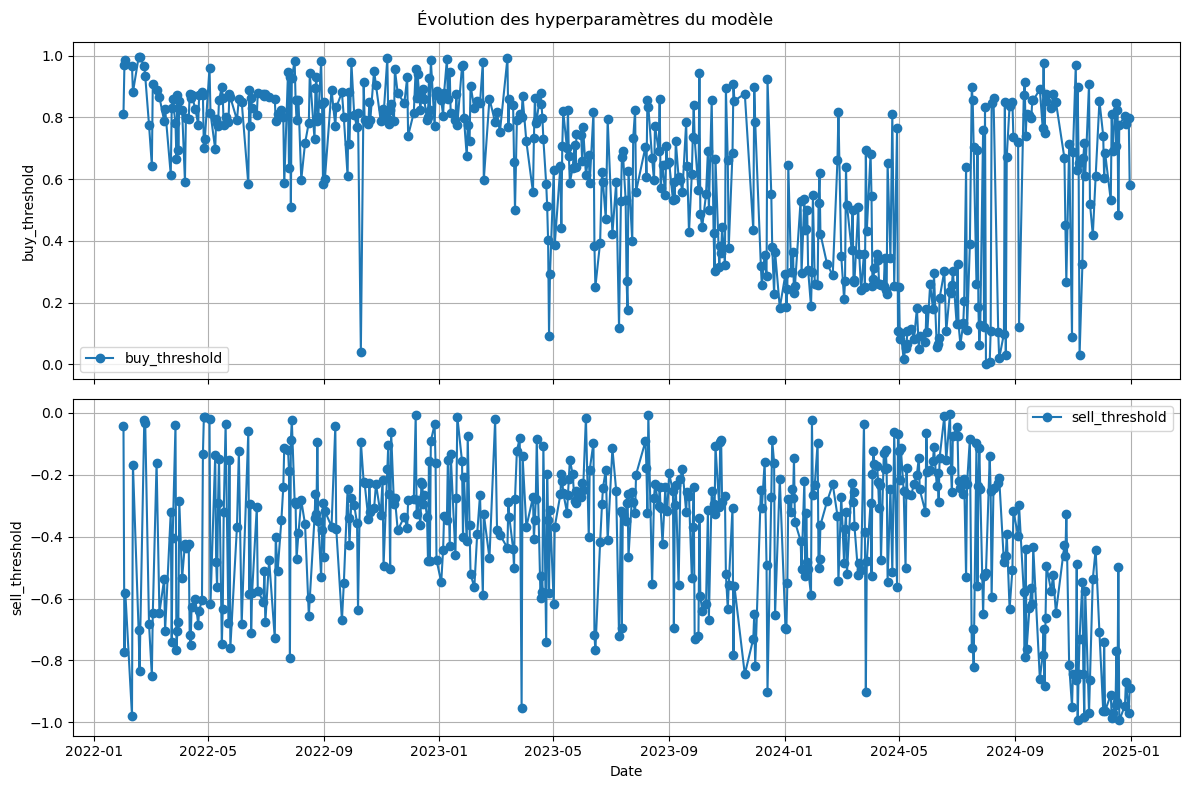

In [293]:
plot_hyperparams_over_time(model_historique, resultats_historique['date'])

In [ ]:
import matplotlib.pyplot as plt

def plot_historique(historique):
    """
    Affiche la courbe du prix d'ouverture avec les signaux d'achat/vente et la valeur du portefeuille.
    Compatible avec l'historique sous forme de dictionnaire.
    """
    df = pd.DataFrame(historique) if isinstance(historique, dict) else historique

    fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

    # 1. Prix d'ouverture + signaux
    axs[0].plot(df['date'], df['Close'], label='Prix d\'ouverture', color='orange')

    buy_signals = df[df['signal'] == 1]
    sell_signals = df[df['signal'] == -1]

    axs[0].scatter(buy_signals['date'], buy_signals['Close'], color='green', marker='^', label='Achat', zorder=5)
    axs[0].scatter(sell_signals['date'], sell_signals['Close'], color='red', marker='v', label='Vente', zorder=5)

    axs[0].set_ylabel('Prix (€)')
    axs[0].legend()
    axs[0].grid()
    axs[0].set_title('Prix d\'ouverture avec signaux d\'achat/vente')

    # 2. Valeur du portefeuille
    axs[1].plot(df['date'],df['Close']/df['Close'][0]*100, label='Prix d\'ouverture', color='orange')
    axs[1].plot(df['date'], df['valeur_portefeuille']/1000*100, label='Pourcentage de la Valeur portefeuille', color='blue')
    axs[1].plot(df['date'], [100 for _ in range(len(df))], label='Cash départ', color='grey', linestyle='--')
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('Valeur (€)')
    axs[1].legend()
    axs[1].grid()
    axs[1].set_title('Évolution de la valeur du portefeuille')

    plt.tight_layout()
    plt.show()

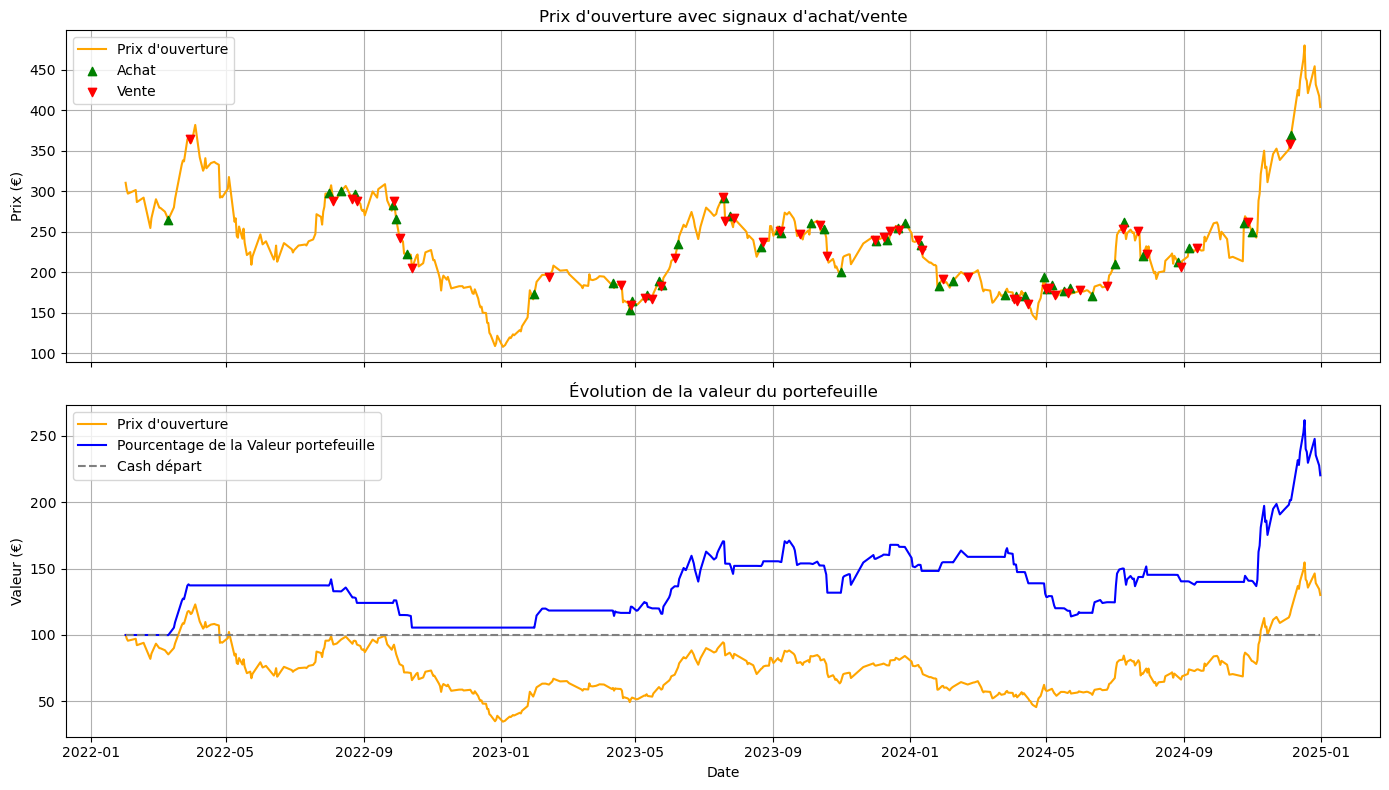

In [295]:
plot_historique(resultats_historique)

## **Analyse graphique**
### **Haut du graphique – Prix avec signaux de trading :**

On capte assez bien les impulsions haussières, surtout à mis et en fin de période.  
On arrive à éviter les plus grosses baisses début 2023 : bons signaux de vente.  
Certaines zones latérales sont "non-tradées", ce qui t’évite de faire des erreurs.  

### **Bas du graphique – Valeur du portefeuille vs prix de l’action :**

Le portefeuille résiste bien aux baisses, notamment 2022–2023.  
On surperforme l'action Tesla dans les périodes de creux.  

In [299]:
import numpy as np
import pandas as pd

def analyser_performance_portefeuille(historique, cash_initial=1000, risk_free_rate=0.0):
    # Convertir l'historique en DataFrame et trier par date
    df = pd.DataFrame(historique).copy()
    df = df.sort_values(by='date')
    
    # S'assurer que la colonne est bien en float pour les calculs
    df['valeur_portefeuille'] = df['valeur_portefeuille'].astype(float)
    
    # Calcul du rendement journalier (variation en % jour par jour)
    df['rendement_journalier'] = df['valeur_portefeuille'].pct_change()

    # Calcul du rendement total sur toute la période
    total_return = (df['valeur_portefeuille'].iloc[-1] / cash_initial) - 1

    # Nombre de jours d'investissement
    nb_jours = len(df)

    # Annualisation du rendement (en supposant 252 jours de bourse par an)
    rendement_annuel = (1 + total_return)**(252 / nb_jours) - 1

    # Volatilité annualisée : écart-type des rendements journaliers * racine de 252
    volatilite_annuelle = df['rendement_journalier'].std() * np.sqrt(252)

    # Sharpe Ratio : rendement excédentaire divisé par la volatilité
    sharpe_ratio = (rendement_annuel - risk_free_rate) / volatilite_annuelle if volatilite_annuelle > 0 else np.nan

    # Max Drawdown : plus grande baisse relative par rapport au précédent sommet
    cumulative = df['valeur_portefeuille'].cummax()  # Plus haut atteint jusqu'à chaque date
    drawdown = (df['valeur_portefeuille'] - cumulative) / cumulative
    max_drawdown = drawdown.min()

    # Résumé des statistiques
    stats = {
        "Rendement total (%)": total_return * 100,
        "Rendement annualisé (%)": rendement_annuel * 100,
        "Volatilité annualisée (%)": volatilite_annuelle * 100,
        "Max Drawdown (%)": max_drawdown * 100,
        "Sharpe Ratio": sharpe_ratio
    }

    return stats, df


In [300]:
stats,df = analyser_performance_portefeuille(resultats_historique, cash_initial=1000, risk_free_rate=0.0)

In [301]:
stats

{'Rendement total (%)': 120.12794937488431,
 'Rendement annualisé (%)': 50.80566629899788,
 'Volatilité annualisée (%)': 42.89322390450711,
 'Max Drawdown (%)': -33.364504939454775,
 'Sharpe Ratio': 1.1844683536053662}

## Résumé des indicateurs clés

| **Indicateur**           | **Valeur**     | **Analyse**                                                                 |
|--------------------------|----------------|------------------------------------------------------------------------------|
| Rendement total          | +120.12 %       | Excellent sur ~3 ans, on a réussi à doubler le capital de départ.          |
| Rendement annualisé      | +50.80 %       | Bien supérieur au S&P 500 moyen (~10 %), très bon.                         |
| Volatilité annualisée    | 42.89 %        | Assez élevée, mais normale vu que c'est une stratégie active.                      |
| Max Drawdown             | -33.36 %       | Acceptable. Reste dans une zone raisonnable compte tenu du rendement.     |
| Sharpe Ratio             | 1.18           | Bon (au-dessus de 1), indique que le risque est bien rémunéré.       |